## Project 3


In [240]:
# import packages
import numpy as np 
import pandas as pd 
import os 
from matplotlib import pyplot as plt
import warnings
import time
from scipy.sparse import coo_matrix
warnings.filterwarnings('ignore')

from surprise.dataset import Dataset
from surprise.similarities import pearson
from surprise.prediction_algorithms import knns
from surprise.prediction_algorithms import NMF
from surprise.prediction_algorithms import SVD
from surprise.prediction_algorithms import BaselineOnly

from surprise import Reader
from surprise.model_selection.split import KFold, train_test_split
from surprise.accuracy import mse, rmse
from sklearn import metrics

In [114]:
data_directory = r'/Users/rover/Desktop/2020 Winter/ECE 219/Project 3/ml-latest-small'
os.chdir(data_directory)

# links = pd.read_csv('links.csv')
# movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv') # only movie rating is used in this project
tags = pd.read_csv('tags.csv') # used for movie genre

### MovieLens dataset

$\textbf{Question 1}$: Compute the sparsity of the movie rating dataset, where spar- sity is defined by equation 1 
Sparsity = Total number of available ratings / Total number of possible ratings

In [3]:
# create rating matrix R
matrix = coo_matrix((ratings.rating.to_list(), (ratings.userId.to_list(), ratings.movieId.to_list()))).toarray()
R = pd.DataFrame(index = range(611), columns= ratings['movieId'].unique(), data = matrix[:, ratings.movieId.unique()])
R = R.drop(R.index[0])
R.replace(0, np.nan, inplace = True)

# compute sparcity
num_movie = len(ratings['movieId'].unique())
num_user = len(ratings['userId'].unique())
sparcity = 1 - R.isna().sum().sum()/(num_movie * num_user)
print('The sparsity index of the rating matrix is %.4f'%sparcity)

The sparsity index of the rating matrix is 0.0170


$\textbf{Question 2}$: Plot a histogram showing the frequency of the rating values. To be specific, bin the rating values into intervals of width 0.5 and use the binned rating values as the horizontal axis. Count the number of entries in the ratings matrix R with rating values in the binned intervals and use this count as the vertical axis. Briefly comment on the shape of the histogram


The lowest rating is 0.5000
The highest rating is 5.0000
The median rating is 3.5000
The mean rating is 3.5016


Text(0, 0.5, 'Frequency')

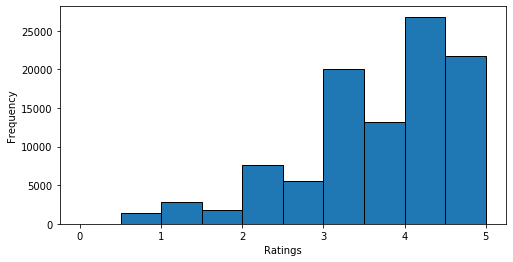

In [4]:
print('The lowest rating is %.4f'%min(ratings['rating']))
print('The highest rating is %.4f'%max(ratings['rating']))
print('The median rating is %.4f'%np.median(ratings['rating']))
print('The mean rating is %.4f'%np.mean(ratings['rating']))

fig, ax = plt.subplots(figsize = (8,4))
ax.hist(ratings['rating'], bins = [0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0], edgecolor='black')
ax.set_xlabel('Ratings')
ax.set_ylabel('Frequency')

$\textbf{Question 3}$: Plot the distribution of the number of ratings received among movies. To be specific, the X-axis should be the movie index ordered by de- creasing frequency and the Y -axis should be the number of ratings the movie has received. For example, the movie that has the largest number of ratings has index 1; ties can broken in any way. A monotonically decreasing curve instead of a histogram is expected.

Text(0, 0.5, 'number of ratings')

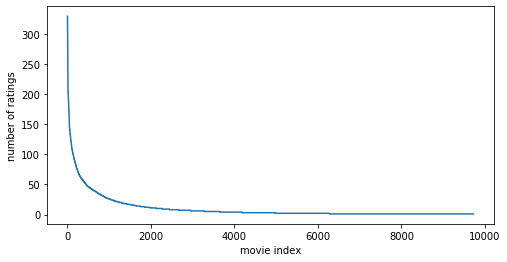

In [5]:
# count the number of ratings for each movie
movie_rate_frequency = pd.DataFrame(index = ratings.movieId.unique(), data = num_user - R.isna().sum(axis = 0))
movie_rate_frequency = movie_rate_frequency.sort_values(by = 0, ascending=False)

fig, ax = plt.subplots(figsize = (8,4))
ax.plot(list(range(num_movie)), movie_rate_frequency[0])
ax.set_xlabel('movie index')
ax.set_ylabel('number of ratings')

$\textbf{Question 4}$: Plot the distribution of ratings among users. To be specific, the X-axis should be the user index ordered by decreasing frequency and the Y -axis should be the number of movies the user have rated. The requirement of the
2 plot is similar to that in Question 3.

Text(0, 0.5, 'number of ratings')

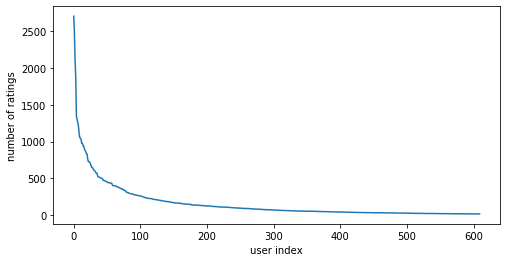

In [6]:
# count the number of ratings for each user
user_rate_frequency = pd.DataFrame(index = ratings.userId.unique(), data = num_movie - R.isna().sum(axis = 1))
user_rate_frequency = user_rate_frequency.sort_values(by = 0, ascending=False)

fig, ax = plt.subplots(figsize = (8,4))
ax.plot(list(range(num_user)), user_rate_frequency[0])
ax.set_xlabel('user index')
ax.set_ylabel('number of ratings')

$\textbf{Question 5}$: Explain the salient features of the distribution found in question 3 and their implications for the recommendation process.

Among all movies, only small proportional of movies receive more than 1 ratings. Most of the movies only be rated by 1 user. 

$\textbf{Question 6}$: Compute the variance of the rating values received by each movie. Then, bin the variance values into intervals of width 0.5 and use the binned variance values as the horizontal axis. Count the number of movies with variance values in the binned intervals and use this count as the vertical axis. Briefly comment on the shape of the histogram

Text(0, 0.5, 'frequency')

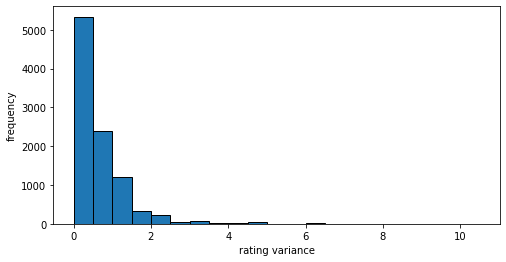

In [8]:
# compute the rating variance of each movie
movie_rate_var = pd.DataFrame(index = ratings.movieId.unique(), data = R.var(axis = 0))
movie_rate_var.replace(np.nan, 0, inplace = True)

fig, ax = plt.subplots(figsize = (8,4))
ax.hist(movie_rate_var[0], bins = [0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0, 8.5, 9.0, 9.5, 10.0, 10.5],edgecolor='black')
ax.set_xlabel('rating variance')
ax.set_ylabel('frequency')

### Neighborhood-based collaborative filtering

#### Pearson-correlation coefficient

$\textbf{Question 7}$: Write down the formula for μu in terms of Iu and ruk

$\mu_u = \frac{1}{|I_u|}\sum_{i \in I_u} r_{ui}$, where $|I_u|$ is the number of elements in $I_u$

$\textbf{Question 8}$: In plain words, explain the meaning of Iu ∩ Iv. Can Iu ∩ Iv = ∅

$I_u \land I_v$ refers to the movies that have been rated by both user $u$ and $v$. $I_u \land I_v$ can be $\phi$, which present user $u$ and $v$ don't have a rated movie in common. This is the main reason that the rating matrix is sparcity.

$\textbf{Question 9}$ Can you explain the reason behind mean-centering the raw ratings in the prediction function?

#### k-NN collaborative filter

In [7]:
class knn_baseline_kfold():
    def __init__(self, n_neighbor, similarity_option, data):
        self.model = knns.KNNBaseline(k = n_neighbor, sim_options = similarity_option)
        self.data = data

    def cross_validation(self, n_folds, trim_flag = False, trim_list = None):
        # define k-fold cross validation
        kf = KFold(n_splits = n_folds)

        # define results dict and list
        results_cache = {}
        rmse_score, mse_score = [], []

        # perform k-fold and store the results
        for train, test in kf.split(self.data):
            self.model.fit(train)

            if trim_flag:
                test = self.trim(test, trim_list)

            # if the trimmed test set is empty, jump to next k-fold
            if len(test) == 0:
                continue 

            preds = self.model.test(test)
            rmse_score.append(rmse(preds))
            mse_score.append(mse(preds))

        results_cache['mean_rmse'], results_cache['mean_mse'], results_cache['rmse_hist'], results_cache['mse_hist'] = np.mean(rmse_score[rmse_score!=0]), np.mean(mse_score[mse_score!=0]), rmse_score, mse_score
        return results_cache

    def trim(self, testset, movieId_list):
        '''
        testset: list, testing data that needed to be trimmed
        trim_list: list, movieId that satisfy the trim requeirement 
        '''
        temp_df = pd.DataFrame(columns = ['userId', 'movieId', 'rate'], data = testset)
        temp = temp_df[temp_df['movieId'].isin(movieId_list)]
        
        return temp.values.tolist()

In [154]:
# prepare data
file_path = os.path.expanduser(r'/Users/rover/Desktop/2020 Winter/ECE 219/Project 3/ml-latest-small/ratings.csv')
reader = Reader(line_format='user item rating', sep=',', rating_scale=(0, 5), skip_lines=1)
data = Dataset.load_from_file(file_path, reader=reader)

$\textbf{Question 10}$ : Design a k-NN collaborative filter to predict the ratings of the movies in the MovieLens dataset and evaluate it’s performance using 10-fold cross validation. Sweep k (number of neighbors) from 2 to 100 in step sizes of 2, and for each k compute the average RMSE and average MAE obtained by averaging the RMSE and MAE across all 10 folds. Plot average RMSE (Y-axis) against k (X-axis) and average MAE (Y-axis) against k (X-axis).


In [15]:
# define number of neighbors
K = np.arange(2, 102, 2)

# define results recorder 
mean_rmse_10, mean_mae_10 = [], []

# perform k-fold cross-validation 
sim_opt = {'name': 'pearson_baseline', 'user_based': False}

for k in K:
    model = knn_baseline_kfold(n_neighbor = k, similarity_option = sim_opt, data = data)
    performance = model.cross_validation(n_folds = 10, trim_flag = False)
    mean_rmse_10.append(performance['mean_rmse'])
    mean_mae_10.append(performance['mean_mse'])

g als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.8390
MSE: 0.7039
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.8450
MSE: 0.7140
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.8568
MSE: 0.7341
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.8447
MSE: 0.7134
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.8491
MSE: 0.7209
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.8429
MSE: 0.7105
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.8402
MSE: 0.7059
Estimating biases using als.

0.8460003969668857
0.7157166716681281


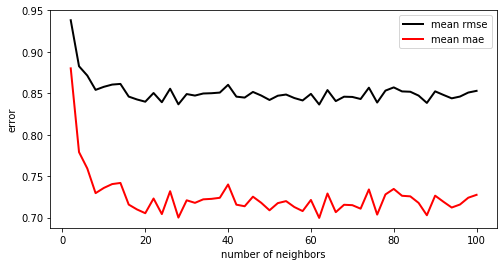

In [25]:
print(mean_rmse_10[20])
print(mean_mae_10[20])
fig, ax = plt.subplots(figsize = (8,4))
ax.plot(K, mean_rmse_10, color = 'black', lw = 2, label = 'mean rmse')
ax.plot(K, mean_mae_10, color = 'red', lw = 2, label = 'mean mae')
ax.set_xlabel('number of neighbors')
ax.set_ylabel('error')
ax.legend()

$\textbf{Question 11}:$ Use the plot from question 10, to find a ’minimum k’. Note: The term ’minimum k’ in this context means that increasing k above the minimum value would not result in a significant decrease in average RMSE or average MAE. If you get the plot correct, then ’minimum k’ would correspond to the k value for which average RMSE and average MAE converges to a steady-state value. Please report the steady state values of average RMSE and average MAE


k = 20, mse = 0.7157, rmse = 0.8460

$\textbf{Question 12}:$ Design a k-NN collaborative filter to predict the ratings of the movies in the popular movie trimmed test set and evaluate it’s performance using 10-fold cross validation. Sweep k (number of neighbors) from 2 to 100 in step sizes of 2, and for each k compute the average RMSE obtained by averaging the RMSE across all 10 folds. Plot average RMSE (Y-axis) against k (X-axis). Also, report the minimum average RMSE

In [16]:
movie_frevar = pd.DataFrame(index = ratings.movieId.unique())
movie_frevar['frequency'] = num_user - R.isna().sum(axis = 0)
movie_frevar['variance'] = R.var(axis = 0)
popular_movieId = movie_rate_frequency[movie_frevar['frequency'] > 2].index.tolist()
popular_movieId = list(map(str, popular_movieId))

unpopular_movieId = movie_rate_frequency[movie_frevar['frequency'] <= 2].index.tolist()
unpopular_movieId = list(map(str, unpopular_movieId))

highvar_movieId = movie_rate_frequency[(movie_frevar['frequency'] >= 5) & (movie_frevar['variance'] >= 2)].index.tolist()
highvar_movieId = list(map(str, highvar_movieId))

In [17]:
# define number of neighbors
K = np.arange(2, 102, 2)

# define results recorder 
mean_rmse_12, mean_mae_12 = [], []

# perform k-fold cross-validation 
sim_opt = {'name': 'pearson_baseline', 'user_based': False}

for k in K:
    model = knn_baseline_kfold(n_neighbor = k, similarity_option = sim_opt, data = data)
    performance = model.cross_validation(n_folds = 10, trim_flag = True, trim_list = popular_movieId)
    mean_rmse_12.append(performance['mean_rmse'])
    mean_mae_12.append(performance['mean_mse'])

g als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.8351
MSE: 0.6974
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.8262
MSE: 0.6826
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.8440
MSE: 0.7123
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.8451
MSE: 0.7143
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.8387
MSE: 0.7035
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.8400
MSE: 0.7056
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.8369
MSE: 0.7005
Estimating biases using als.

0.8451917764487277
0.714349138976556


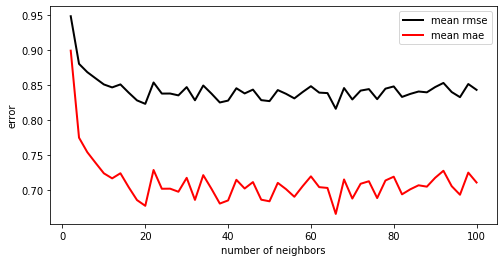

In [26]:
print(mean_rmse_12[20])
print(mean_mae_12[20])
fig, ax = plt.subplots(figsize = (8,4))
ax.plot(K, mean_rmse_12, color = 'black', lw = 2, label = 'mean rmse')
ax.plot(K, mean_mae_12, color = 'red', lw = 2, label = 'mean mae')
ax.set_xlabel('number of neighbors')
ax.set_ylabel('error')
ax.legend()

$\textbf{Question 13}:$ Design a k-NN collaborative filter to predict the ratings of the movies in the unpopular movie trimmed test set and evaluate it’s performance using 10-fold cross validation. Sweep k (number of neighbors) from 2 to 100 in step sizes of 2, and for each k compute the average RMSE obtained by averaging the RMSE across all 10 folds. Plot average RMSE (Y-axis) against k (X-axis). Also, report the minimum average RMSE

In [29]:
# define number of neighbors
K = np.arange(2, 102, 2)

# define results recorder 
mean_rmse_13, mean_mae_13 = [], []

# perform k-fold cross-validation 
sim_opt = {'name': 'pearson_baseline', 'user_based': False}

for k in K:
    model = knn_baseline_kfold(n_neighbor = k, similarity_option = sim_opt, data = data)
    performance = model.cross_validation(n_folds = 10, trim_flag = True, trim_list = unpopular_movieId)
    mean_rmse_13.append(performance['mean_rmse'])
    mean_mae_13.append(performance['mean_mse'])

g als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 1.0030
MSE: 1.0061
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9360
MSE: 0.8760
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9061
MSE: 0.8211
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9635
MSE: 0.9283
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9740
MSE: 0.9486
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9558
MSE: 0.9135
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 1.0180
MSE: 1.0363
Estimating biases using als.

0.889321106951945
0.7908920312702328


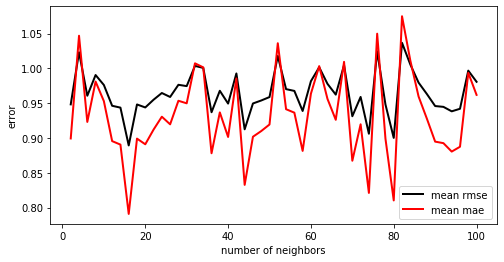

In [36]:
print(min(mean_rmse_13))
print(min(mean_mae_13))
fig, ax = plt.subplots(figsize = (8,4))
ax.plot(K, mean_rmse_13, color = 'black', lw = 2, label = 'mean rmse')
ax.plot(K, mean_mae_13, color = 'red', lw = 2, label = 'mean mae')
ax.set_xlabel('number of neighbors')
ax.set_ylabel('error')
ax.legend()

$\textbf{Question 14}:$ Design a k-NN collaborative filter to predict the ratings of the movies in the high variance movie trimmed test set and evaluate it’s perfor- mance using 10-fold cross validation. Sweep k (number of neighbors) from 2 to 100 in step sizes of 2, and for each k compute the average RMSE obtained by averaging the RMSE across all 10 folds. Plot average RMSE (Y-axis) against k (X-axis). Also, report the minimum average RMSE


In [31]:
# define number of neighbors
K = np.arange(2, 102, 2)

# define results recorder 
mean_rmse_14, mean_mae_14 = [], []

# perform k-fold cross-validation 
sim_opt = {'name': 'pearson_baseline', 'user_based': False}

for k in K:
    model = knn_baseline_kfold(n_neighbor = k, similarity_option = sim_opt, data = data)
    performance = model.cross_validation(n_folds = 10, trim_flag = True, trim_list = highvar_movieId)
    mean_rmse_14.append(performance['mean_rmse'])
    mean_mae_14.append(performance['mean_mse'])

g als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 1.4759
MSE: 2.1783
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 1.5230
MSE: 2.3195
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 1.3344
MSE: 1.7806
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 1.4854
MSE: 2.2064
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 1.2906
MSE: 1.6658
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 1.3006
MSE: 1.6917
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 1.3329
MSE: 1.7766
Estimating biases using als.

1.4308188911128283
2.0472426991653436


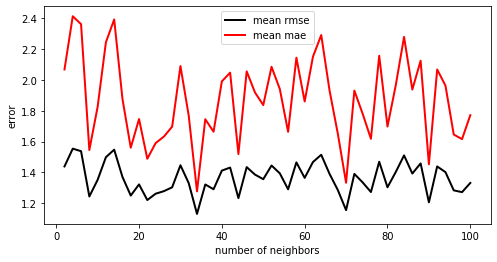

In [32]:
print(mean(mean_rmse_14))
print(mean(mean_mae_14))
fig, ax = plt.subplots(figsize = (8,4))
ax.plot(K, mean_rmse_14, color = 'black', lw = 2, label = 'mean rmse')
ax.plot(K, mean_mae_14, color = 'red', lw = 2, label = 'mean mae')
ax.set_xlabel('number of neighbors')
ax.set_ylabel('error')
ax.legend()

$\textbf{Question 15}:$ Plot the ROC curves for the k-NN collaborative filter designed in question 10 for threshold values [2.5, 3, 3.5, 4]. For the ROC plotting use the k found in question 11. For each of the plots, also report the area under the curve (AUC) value.

In [33]:
# use k = 20 from problem 10
model_15 = knns.KNNBaseline(k = 20, sim_options = sim_opt)
data_train, data_test = train_test_split(data, test_size = 0.1, shuffle = True)
model_15.fit(data_train)
test_pred = model_15.test(data_test)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [34]:
# make ROC plot
true_test_rating = [data_test[p][2] for p in range(len(data_test))]
pred_test_rating = [test_pred[p][3] for p in range(len(test_pred))]
threshold = [2.5, 3, 3.5, 4]
fprs, tprs = [], []
roc_auc = []
for t in threshold:
    true_test_bi = np.array(true_test_rating) > t
    fpr, tpr, _ = metrics.roc_curve(true_test_bi, pred_test_rating)
    roc_auc.append(metrics.auc(fpr, tpr))
    fprs.append(fpr)
    tprs.append(tpr)

The roc areas of the 4 thresholds are [0.8046096845843571, 0.7894062134373945, 0.7900170635523271, 0.7883828882088375] , respectively


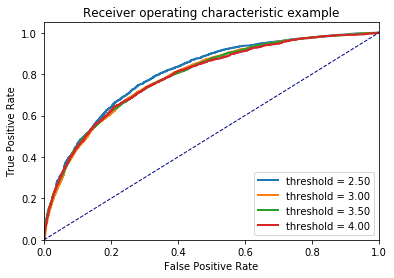

In [35]:
for i in range(4):
    plt.plot(fprs[i], tprs[i], lw=2, label = 'threshold = %.2f'%threshold[i])

plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
print('The roc areas of the 4 thresholds are', roc_auc, ', respectively')

$\textbf{Question 16}$: Is the optimization problem given by equation 5 convex? Consider the optimization problem given by equation 5. For U fixed, formulate it as a least-squares problem.

### Model-based collaborative filtering

#### Non-negative matrix factorization (NNMF)

In [221]:
class nmf_kfold():
    def __init__(self, num_factors, num_epoch, data):
        self.model = NMF(n_factors = num_factors, n_epochs = num_epoch, biased = True)
        self.data = data

    def cross_validation(self, n_folds, trim_flag = False, trim_list = None):
        # define k-fold cross validation
        kf = KFold(n_splits = n_folds)

        # define results dict and list
        results_cache = {}
        rmse_score, mse_score = [], []

        # perform k-fold and store the results
        for train, test in kf.split(self.data):
            self.model.fit(train)

            if trim_flag:
                test = self.trim(test, trim_list)

            # if the trimmed test set is empty, jump to next k-fold
            if len(test) == 0:
                continue 

            preds = self.model.test(test)
            rmse_score.append(rmse(preds))
            mse_score.append(mse(preds))

        results_cache['mean_rmse'], results_cache['mean_mse'], results_cache['rmse_hist'], results_cache['mse_hist'] = np.mean(rmse_score[rmse_score!=0]), np.mean(mse_score[mse_score!=0]), rmse_score, mse_score
        return results_cache

    def trim(self, testset, movieId_list):
        '''
        testset: list, testing data that needed to be trimmed
        trim_list: list, movieId that satisfy the trim requeirement 
        '''
        temp_df = pd.DataFrame(columns = ['userId', 'movieId', 'rate'], data = testset)
        temp = temp_df[temp_df['movieId'].isin(movieId_list)]
        
        return temp.values.tolist()

$\textbf{Question 17}$ Design a NNMF-based collaborative filter to predict the ratings of the movies in the MovieLens dataset and evaluate it’s performance using 10-fold cross-validation. Sweep k (number of latent factors) from 2 to 50 in step sizes of 2, and for each k compute the average RMSE and average MAE obtained by averaging the RMSE and MAE across all 10 folds. Plot the average RMSE (Y-axis) against k (X-axis) and the average MAE (Y-axis) against k (X-axis). For solving this question, use the default value for the regularization parameter.


In [224]:
# define number of factors
K = np.arange(2, 52, 2)

# define results recorder 
mean_rmse_17, mean_mae_17 = [], []

# perform k-fold cross validation 
for k in K:
    model = nmf_kfold(num_factors = k, num_epoch = 30, data = data)
    performance = model.cross_validation(n_folds = 10, trim_flag = False)
    mean_rmse_17.append(performance['mean_rmse'])
    mean_mae_17.append(performance['mean_mse'])

RMSE: 0.8737
MSE: 0.7634
RMSE: 0.8660
MSE: 0.7499
RMSE: 0.8515
MSE: 0.7251
RMSE: 0.8703
MSE: 0.7574
RMSE: 0.8714
MSE: 0.7593
RMSE: 0.8765
MSE: 0.7682
RMSE: 0.8636
MSE: 0.7457
RMSE: 0.8711
MSE: 0.7589
RMSE: 0.8657
MSE: 0.7494
RMSE: 0.8655
MSE: 0.7491
RMSE: 0.8678
MSE: 0.7531
RMSE: 0.8694
MSE: 0.7558
RMSE: 0.8665
MSE: 0.7508
RMSE: 0.8660
MSE: 0.7499
RMSE: 0.8610
MSE: 0.7414
RMSE: 0.8704
MSE: 0.7575
RMSE: 0.8632
MSE: 0.7450
RMSE: 0.8744
MSE: 0.7645
RMSE: 0.8829
MSE: 0.7795
RMSE: 0.8622
MSE: 0.7435
RMSE: 0.8744
MSE: 0.7646
RMSE: 0.8702
MSE: 0.7572
RMSE: 0.8751
MSE: 0.7659
RMSE: 0.8706
MSE: 0.7579
RMSE: 0.8774
MSE: 0.7698
RMSE: 0.8627
MSE: 0.7443
RMSE: 0.8654
MSE: 0.7489
RMSE: 0.8774
MSE: 0.7698
RMSE: 0.8614
MSE: 0.7420
RMSE: 0.8681
MSE: 0.7536
RMSE: 0.8832
MSE: 0.7800
RMSE: 0.8624
MSE: 0.7438
RMSE: 0.8692
MSE: 0.7556
RMSE: 0.8618
MSE: 0.7426
RMSE: 0.8852
MSE: 0.7835
RMSE: 0.8622
MSE: 0.7434
RMSE: 0.8874
MSE: 0.7875
RMSE: 0.8621
MSE: 0.7432
RMSE: 0.8810
MSE: 0.7762
RMSE: 0.8692
MSE: 0.7555


0.8624311261825328
0.7437874474084718
3
3


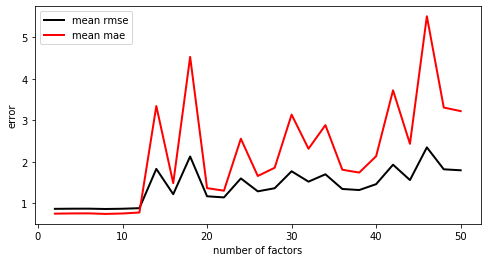

In [229]:
print(min(mean_rmse_17))
print(min(mean_mae_17))
print(np.argmin(mean_rmse_17))
print(np.argmin(mean_mae_17))
fig, ax = plt.subplots(figsize = (8,4))
ax.plot(K, mean_rmse_17, color = 'black', lw = 2, label = 'mean rmse')
ax.plot(K, mean_mae_17, color = 'red', lw = 2, label = 'mean mae')
ax.set_xlabel('number of factors')
ax.set_ylabel('error')
ax.legend()

$\textbf{Question 18}$ Use the plot from question 17, to find the optimal number of latent factors. Optimal number of latent factors is the value of k that gives the minimum average RMSE or the minimum average MAE. Please report the minimum average RMSE and MAE. Is the optimal number of latent factors same as the number of movie genres?

$\textbf{Question 19}$ Design a NNMF collaborative filter to predict the ratings of the movies in the popular movie trimmed test set and evaluate it’s performance using 10-fold cross validation. Sweep k (number of latent factors) from 2 to 50 in step sizes of 2, and for each k compute the average RMSE obtained by averaging the RMSE across all 10 folds. Plot average RMSE (Y-axis) against k (X-axis). Also, report the minimum average RMSE

In [ ]:
# define number of neighbors
K = np.arange(2, 52, 2)

# define results recorder 
mean_rmse_19, mean_mae_19 = [], []

# perform k-fold cross-validation 
for k in K:
    model = nmf_kfold(num_factors = k, num_epoch = 50, data = data)
    performance = model.cross_validation(n_folds = 10, trim_flag = True, trim_list = popular_movieId)
    mean_rmse_19.append(performance['mean_rmse'])
    mean_mae_19.append(performance['mean_mse'])

In [ ]:
print(min(mean_rmse_19))
print(min(mean_mae_19))
fig, ax = plt.subplots(figsize = (8,4))
ax.plot(K, mean_rmse_19, color = 'black', lw = 2, label = 'mean rmse')
ax.plot(K, mean_mae_19, color = 'red', lw = 2, label = 'mean mae')
ax.set_xlabel('number of factors')
ax.set_ylabel('error')
ax.legend()

$\textbf{Question 20}$ Design a NNMF collaborative filter to predict the ratings of the movies in the unpopular movie trimmed test set and evaluate it’s performance using 10-fold cross validation. Sweep k (number of latent factors) from 2 to 50 in step sizes of 2, and for each k compute the average RMSE obtained by averaging the RMSE across all 10 folds. Plot average RMSE (Y-axis) against k (X-axis). Also, report the minimum average RMSE

In [ ]:
# define number of neighbors
K = np.arange(2, 52, 2)

# define results recorder 
mean_rmse_20, mean_mae_20 = [], []

# perform k-fold cross-validation 
for k in K:
    model = nmf_kfold(num_factors = k, num_epoch = 50, data = data)
    performance = model.cross_validation(n_folds = 10, trim_flag = True, trim_list = unpopular_movieId)
    mean_rmse_20.append(performance['mean_rmse'])
    mean_mae_20.append(performance['mean_mse'])

In [ ]:
print(min(mean_rmse_20))
print(min(mean_mae_20))
fig, ax = plt.subplots(figsize = (8,4))
ax.plot(K, mean_rmse_20, color = 'black', lw = 2, label = 'mean rmse')
ax.plot(K, mean_mae_20, color = 'red', lw = 2, label = 'mean mae')
ax.set_xlabel('number of factors')
ax.set_ylabel('error')
ax.legend()

$\textbf{Question 21}$ Design a NNMF collaborative filter to predict the ratings of the movies in the high variance movie trimmed test set and evaluate it’s perfor- mance using 10-fold cross validation. Sweep k (number of latent factors) from 2 to 50 in step sizes of 2, and for each k compute the average RMSE obtained by averaging the RMSE across all 10 folds. Plot average RMSE (Y-axis) against k (X-axis). Also, report the minimum average RMSE

In [ ]:
# define number of neighbors
K = np.arange(2, 52, 2)

# define results recorder 
mean_rmse_21, mean_mae_21 = [], []

# perform k-fold cross-validation 
for k in K:
    model = nmf_kfold(num_factors = k, num_epoch = 50, data = data)
    performance = model.cross_validation(n_folds = 10, trim_flag = True, trim_list = unpopular_movieId)
    mean_rmse_21.append(performance['mean_rmse'])
    mean_mae_21.append(performance['mean_mse'])

In [ ]:
print(min(mean_rmse_21))
print(min(mean_mae_21))
fig, ax = plt.subplots(figsize = (8,4))
ax.plot(K, mean_rmse_21, color = 'black', lw = 2, label = 'mean rmse')
ax.plot(K, mean_mae_21, color = 'red', lw = 2, label = 'mean mae')
ax.set_xlabel('number of factors')
ax.set_ylabel('error')
ax.legend()

$\textbf{Question 22}$: Plot the ROC curves for the NNMF-based collaborative filter designed in question 17 for threshold values [2.5,3,3.5,4]. For the ROC plot- ting use the optimal number of latent factors found in question 18. For each of the plots, also report the area under the curve (AUC) value.

In [230]:
# use k = 12 from problem 17
model_22 = NMF(n_factors = 3)
data_train, data_test = train_test_split(data, test_size = 0.1, shuffle = True)
model_22.fit(data_train)
test_pred_22 = model_22.test(data_test)

In [231]:
# make ROC plot
true_test_rating = [data_test[p][2] for p in range(len(data_test))]
pred_test_rating = [test_pred[p][3] for p in range(len(test_pred_22))]
threshold = [2.5, 3, 3.5, 4]
fprs, tprs = [], []
roc_auc = []
for t in threshold:
    true_test_bi = np.array(true_test_rating) > t
    fpr, tpr, _ = metrics.roc_curve(true_test_bi, pred_test_rating)
    roc_auc.append(metrics.auc(fpr, tpr))
    fprs.append(fpr)
    tprs.append(tpr)

The roc areas of the 4 thresholds are [0.4868285097894318, 0.4932992666843725, 0.5000625853158454, 0.5085949077358302] , respectively


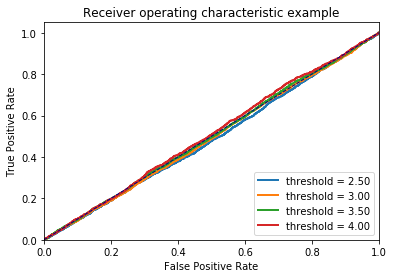

In [232]:
for i in range(4):
    plt.plot(fprs[i], tprs[i], lw=2, label = 'threshold = %.2f'%threshold[i])

plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
print('The roc areas of the 4 thresholds are', roc_auc, ', respectively')

$\textbf{Question 23}$: Perform Non-negative matrix factorization on the ratings matrix R to obtain the factor matrices U and V , where U represents the user-latent factors interaction and V represents the movie-latent factors interaction (use k = 20). For each column of V , sort the movies in descending order and report the genres of the top 10 movies. Do the top 10 movies belong to a particular or a small collection of genre? Is there a connection between the latent factors and the movie genres?

In [155]:
# compute latent factors of movies using NMF
model_23 = NMF(n_factors = 20)
model_23.fit(data.build_full_trainset())
V = model_23.qi

In [219]:
# collect the inner item ids with the top 10 largest latent factors
top_movie_factors = np.empty(shape = [10, 20])
top_factors_movieId = np.empty(shape = [10, 20])
for i in range(20):
    top_factors_movieId[:, i] = V[:,i].argsort()[-10:]
    top_movie_factors[:, i] = np.sort(V[:,i])[-10:]

# report the results for column 0
col_zero_ids = []
col_zero_genres = []

raw_ids = [model_23.trainset.to_raw_iid(p) for p in top_factors_movieId[:,19]]
movie_genres = [tags.loc[tags['movieId'] == int(q), 'tag'].values for q in raw_ids]

#### Matrix Factorization with Bias (MF with Bias)

In [239]:
class svd_kfold():
    def __init__(self, num_factors, data):
        self.model = SVD(n_factors = num_factors)
        self.data = data

    def cross_validation(self, n_folds, trim_flag = False, trim_list = None):
        # define k-fold cross validation
        kf = KFold(n_splits = n_folds)

        # define results dict and list
        results_cache = {}
        rmse_score, mse_score = [], []

        # perform k-fold and store the results
        for train, test in kf.split(self.data):
            self.model.fit(train)

            if trim_flag:
                test = self.trim(test, trim_list)

            # if the trimmed test set is empty, jump to next k-fold
            if len(test) == 0:
                continue 

            preds = self.model.test(test)
            rmse_score.append(rmse(preds))
            mse_score.append(mse(preds))

        results_cache['mean_rmse'], results_cache['mean_mse'], results_cache['rmse_hist'], results_cache['mse_hist'] = np.mean(rmse_score[rmse_score!=0]), np.mean(mse_score[mse_score!=0]), rmse_score, mse_score
        return results_cache

    def trim(self, testset, movieId_list):
        '''
        testset: list, testing data that needed to be trimmed
        trim_list: list, movieId that satisfy the trim requeirement 
        '''
        temp_df = pd.DataFrame(columns = ['userId', 'movieId', 'rate'], data = testset)
        temp = temp_df[temp_df['movieId'].isin(movieId_list)]
        
        return temp.values.tolist()

$\textbf{Question 24}$: Design a MF with bias collaborative filter to predict the ratings of the movies in the MovieLens dataset and evaluate it’s performance using 10-fold cross-validation. Sweep k (number of latent factors) from 2 to 50 in step sizes of 2, and for each k compute the average RMSE and average MAE obtained by averaging the RMSE and MAE across all 10 folds. Plot the average RMSE (Y-axis) against k (X-axis) and the average MAE (Y-axis) against k (X-axis). For solving this question, use the default value for the regularization parameter.

In [238]:
# define number of factors
K = np.arange(2, 102, 2)

# define results recorder 
mean_rmse_24, mean_mae_24 = [], []

# perform k-fold cross validation 
for k in K:
    model = svd_kfold(num_factors = k, data = data)
    performance = model.cross_validation(n_folds = 10, trim_flag = False)
    mean_rmse_24.append(performance['mean_rmse'])
    mean_mae_24.append(performance['mean_mse'])

RMSE: 0.8697
MSE: 0.7563
RMSE: 0.8632
MSE: 0.7451
RMSE: 0.8736
MSE: 0.7631
RMSE: 0.8496
MSE: 0.7218
RMSE: 0.8633
MSE: 0.7454
RMSE: 0.8696
MSE: 0.7561
RMSE: 0.8763
MSE: 0.7679
RMSE: 0.8707
MSE: 0.7581
RMSE: 0.8694
MSE: 0.7559
RMSE: 0.8629
MSE: 0.7446


In [ ]:
print(min(mean_rmse_24))
print(min(mean_mae_24))
print(np.argmin(mean_rmse_24))
print(np.argmin(mean_mae_24))
fig, ax = plt.subplots(figsize = (8,4))
ax.plot(K, mean_rmse_24, color = 'black', lw = 2, label = 'mean rmse')
ax.plot(K, mean_mae_24, color = 'red', lw = 2, label = 'mean mae')
ax.set_xlabel('number of factors')
ax.set_ylabel('error')
ax.legend()

$\textbf{Question 25}$: Use the plot from question 24, to find the optimal number of latent factors. Optimal number of latent factors is the value of k that gives the minimum average RMSE or the minimum average MAE. Please report the minimum average RMSE and MAE.

$\textbf{Question 26}$: Design a MF with bias collaborative filter to predict the ratings of the movies in the popular movie trimmed test set and evaluate it’s performance using 10-fold cross validation. Sweep k (number of latent factors) from 2 to 50 in step sizes of 2, and for each k compute the average RMSE obtained by averaging the RMSE across all 10 folds. Plot average RMSE (Y-axis) against k (X-axis). Also, report the minimum average RMSE

In [ ]:
# define number of neighbors
K = np.arange(2, 52, 2)

# define results recorder 
mean_rmse_26, mean_mae_26 = [], []

# perform k-fold cross-validation 
for k in K:
    model = svd_kfold(num_factors = k, num_epoch = 50, data = data)
    performance = model.cross_validation(n_folds = 10, trim_flag = True, trim_list = popular_movieId)
    mean_rmse_26.append(performance['mean_rmse'])
    mean_mae_26.append(performance['mean_mse'])

In [ ]:
print(min(mean_rmse_26))
print(min(mean_mae_26))
fig, ax = plt.subplots(figsize = (8,4))
ax.plot(K, mean_rmse_26, color = 'black', lw = 2, label = 'mean rmse')
ax.plot(K, mean_mae_26, color = 'red', lw = 2, label = 'mean mae')
ax.set_xlabel('number of factors')
ax.set_ylabel('error')
ax.legend()

$\textbf{Question 27}$: Design a MF with bias collaborative filter to predict the rat- ings of the movies in the unpopular movie trimmed test set and evaluate it’s performance using 10-fold cross validation. Sweep k (number of latent factors) from 2 to 50 in step sizes of 2, and for each k compute the average RMSE ob- tained by averaging the RMSE across all 10 folds. Plot average RMSE (Y-axis) against k (X-axis). Also, report the minimum average RMSE

In [ ]:
# define number of neighbors
K = np.arange(2, 52, 2)

# define results recorder 
mean_rmse_27, mean_mae_27 = [], []

# perform k-fold cross-validation 
for k in K:
    model = svd_kfold(num_factors = k, num_epoch = 50, data = data)
    performance = model.cross_validation(n_folds = 10, trim_flag = True, trim_list = unpopular_movieId)
    mean_rmse_27.append(performance['mean_rmse'])
    mean_mae_27.append(performance['mean_mse'])

In [ ]:
print(min(mean_rmse_27))
print(min(mean_mae_27))
fig, ax = plt.subplots(figsize = (8,4))
ax.plot(K, mean_rmse_27, color = 'black', lw = 2, label = 'mean rmse')
ax.plot(K, mean_mae_27, color = 'red', lw = 2, label = 'mean mae')
ax.set_xlabel('number of factors')
ax.set_ylabel('error')
ax.legend()

$\textbf{Question 28}$: Design a MF with bias collaborative filter to predict the rat- ings of the movies in the high variance movie trimmed test set and evaluate it’s performance using 10-fold cross validation. Sweep k (number of latent factors) from 2 to 50 in step sizes of 2, and for each k compute the average RMSE ob- tained by averaging the RMSE across all 10 folds. Plot average RMSE (Y-axis) against k (X-axis). Also, report the minimum average RMSE

In [ ]:
# define number of neighbors
K = np.arange(2, 52, 2)

# define results recorder 
mean_rmse_28, mean_mae_28 = [], []

# perform k-fold cross-validation 
for k in K:
    model = svd_kfold(num_factors = k, num_epoch = 50, data = data)
    performance = model.cross_validation(n_folds = 10, trim_flag = True, trim_list = highvar_movieId)
    mean_rmse_28.append(performance['mean_rmse'])
    mean_mae_28.append(performance['mean_mse'])

In [ ]:
print(min(mean_rmse_28))
print(min(mean_mae_28))
fig, ax = plt.subplots(figsize = (8,4))
ax.plot(K, mean_rmse_28, color = 'black', lw = 2, label = 'mean rmse')
ax.plot(K, mean_mae_28, color = 'red', lw = 2, label = 'mean mae')
ax.set_xlabel('number of factors')
ax.set_ylabel('error')
ax.legend()


$\textbf{Question 29}$: Plot the ROC curves for the MF with bias collaborative filter designed in question 24 for threshold values [2.5,3,3.5,4]. For the ROC plot- ting use the optimal number of latent factors found in question 25. For each of the plots, also report the area under the curve (AUC) value.


In [ ]:
# use k = 12 from problem 17
model_29 = SVD(n_factors = 3)
data_train, data_test = train_test_split(data, test_size = 0.1, shuffle = True)
model_29.fit(data_train)
test_pred_29 = model_29.test(data_test)

In [ ]:
# make ROC plot
true_test_rating = [data_test[p][2] for p in range(len(data_test))]
pred_test_rating = [test_pred[p][3] for p in range(len(test_pred_29))]
threshold = [2.5, 3, 3.5, 4]
fprs, tprs = [], []
roc_auc = []
for t in threshold:
    true_test_bi = np.array(true_test_rating) > t
    fpr, tpr, _ = metrics.roc_curve(true_test_bi, pred_test_rating)
    roc_auc.append(metrics.auc(fpr, tpr))
    fprs.append(fpr)
    tprs.append(tpr)

In [ ]:
for i in range(4):
    plt.plot(fprs[i], tprs[i], lw=2, label = 'threshold = %.2f'%threshold[i])

plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
print('The roc areas of the 4 thresholds are', roc_auc, ', respectively')

### Naive collaborative filtering

$\textbf{Question 30}$: Design a naive collaborative filter to predict the ratings of the movies in the MovieLens dataset and evaluate it’s performance using 10-fold cross validation. Compute the average RMSE by averaging the RMSE across all 10 folds. Report the average RMSE.
Note that in this case, when performing the cross-validation, there is no need to calculate μi’s for the training folds each time. You are only asked to use a sin- gle set of μi’s calculated on the entire dataset and validate on 10 validation folds.

In [ ]:
class naive_kfold():
    def __init__(self, num_factors, data):
        self.model = BaselineOnly(n_factors = num_factors)
        self.data = data

    def cross_validation(self, n_folds, trim_flag = False, trim_list = None):
        # define k-fold cross validation
        kf = KFold(n_splits = n_folds)

        # define results dict and list
        results_cache = {}
        rmse_score, mse_score = [], []

        # perform k-fold and store the results
        for train, test in kf.split(self.data):
            self.model.fit(train)

            if trim_flag:
                test = self.trim(test, trim_list)

            # if the trimmed test set is empty, jump to next k-fold
            if len(test) == 0:
                continue 

            preds = self.model.test(test)
            rmse_score.append(rmse(preds))
            mse_score.append(mse(preds))

        results_cache['mean_rmse'], results_cache['mean_mse'], results_cache['rmse_hist'], results_cache['mse_hist'] = np.mean(rmse_score[rmse_score!=0]), np.mean(mse_score[mse_score!=0]), rmse_score, mse_score
        return results_cache

    def trim(self, testset, movieId_list):
        '''
        testset: list, testing data that needed to be trimmed
        trim_list: list, movieId that satisfy the trim requeirement 
        '''
        temp_df = pd.DataFrame(columns = ['userId', 'movieId', 'rate'], data = testset)
        temp = temp_df[temp_df['movieId'].isin(movieId_list)]
        
        return temp.values.tolist()

$\textbf{Question 31}$: Design a naive collaborative filter to predict the ratings of the movies in the popular movie trimmed test set and evaluate it’s performance using 10-fold cross validation. Compute the average RMSE by averaging the RMSE across all 10 folds. Report the average RMSE.


$\textbf{Question 32}$: Design a naive collaborative filter to predict the ratings of the movies in the unpopular movie trimmed test set and evaluate it’s performance using 10-fold cross validation. Compute the average RMSE by averaging the RMSE across all 10 folds. Report the average RMSE.

$\textbf{Question 33}$: Design a naive collaborative filter to predict the ratings of the movies in the high variance movie trimmed test set and evaluate it’s perfor- mance using 10-fold cross validation. Compute the average RMSE by averaging the RMSE across all 10 folds. Report the average RMSE.


$\textbf{Question 34}$: Plot the ROC curves (threshold = 3) for the k-NN, NNMF, and MF with bias based collaborative filters in the same figure. Use the figure to compare the performance of the filters in predicting the ratings of the movies.

$\textbf{Question 35}$: Precision and Recall are defined by the mathematical expres- sions given by equations 12 and 13 respectively. Please explain the meaning of precision and recall in your own words.

$\textbf{Question 36}$: Plot average precision (Y-axis) against t (X-axis) for the rank- ing obtained using k-NN collaborative filter predictions. Also, plot the average recall (Y-axis) against t (X-axis) and average precision (Y-axis) against average recall (X-axis). Use the k found in question 11 and sweep t from 1 to 25 in step sizes of 1. For each plot, briefly comment on the shape of the plot.



$\textbf{Question 37}$: Plot average precision (Y-axis) against t (X-axis) for the rank- ing obtained using NNMF-based collaborative filter predictions. Also, plot the average recall (Y-axis) against t (X-axis) and average precision (Y-axis) against average recall (X-axis). Use optimal number of latent factors found in question 18 and sweep t from 1 to 25 in step sizes of 1. For each plot, briefly comment on the shape of the plot.

$\textbf{Question 38}$: Plot average precision (Y-axis) against t (X-axis) for the ranking obtained using MF with bias-based collaborative filter predictions. Also, plot the average recall (Y-axis) against t (X-axis) and average precision (Y-axis) against average recall (X-axis). Use optimal number of latent factors found in question 25 and sweep t from 1 to 25 in step sizes of 1. For each plot, briefly comment on the shape of the plot.

$\textbf{Question 39}$: Plot the precision-recall curve obtained in questions 36,37, and 38 in the same figure. Use this figure to compare the relevance of the recom- mendation list generated using k-NN, NNMF, and MF with bias predictions.